In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Naive Bayes from scratch

In [ ]:
from sklearn.datasets import make_blobs
import seaborn as sns
import pandas as pd

### Dataset sintético

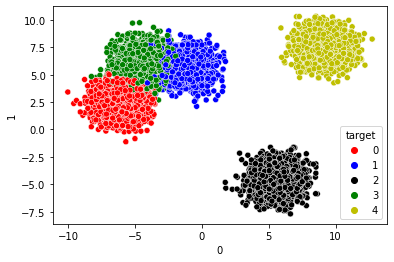

In [ ]:
x, y = make_blobs(n_samples=10000, centers=5, random_state=1234)
dataset = pd.DataFrame(x)
dataset["target"] = y

sns.scatterplot(
    x=0,
    y=1,
    hue="target",
    palette={0: "r", 1: "b", 2: "k", 3: "g", 4: "y"},
    data=dataset,
    legend="brief",
)

Vamos a codear desde cero el algoritmo de Naive Bayes usando distribuciones gaussianas. El primer paso es poder obtener $p(x|c_k)$. Si modelamos esta probabilidad utilizando una distribución normal, entonces cada clase tendrá asociada una media y un desvío estandar. Escribamos una función que devuelva la probabilidad de x dada una media y desvio estandar.

$f(x;0,1) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$

$f(x;\mu,\sigma) = f(\frac{x-\mu}{\sigma};0,1)$

In [ ]:
def prob_standard_normal(x):
    return np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)


def prob_normal(x, mean, std):
    return prob_standard_normal((x - mean) / std) / std

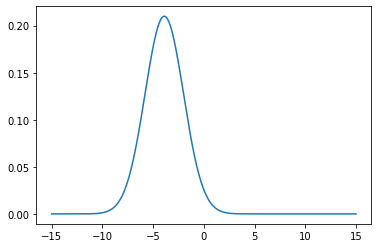

In [ ]:
# @title Distribución normal
mean = -3.9  # @param {type:"slider", min:-10, max:10, step:0.1}
std = 1.9  # @param {type:"slider", min:0, max:5, step:0.1}

x = np.linspace(-15, 15, 1000)
plt.plot(x, prob_normal(x, mean, std))

Ahora debemos encontrar, para cada clase $c_k$, los parámetros $\mu$ y $\sigma$ que mejor aproximen a los datos de entrenamiento. Podemos pensar el "que mejor aproximen" como el que maximice el likelihood.

Text(5, 0.22796697017247017, 'Log Likelihood: -762.409')

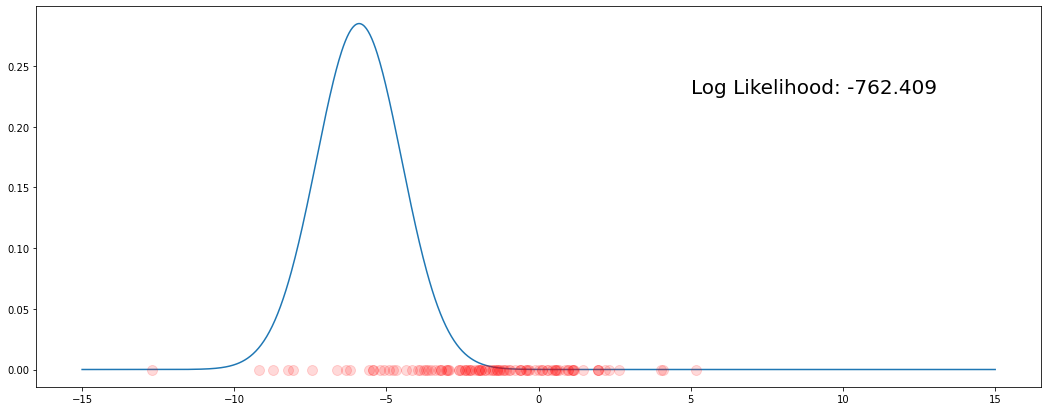

In [ ]:
# @title Distribución normal y likelihood
mean = -5.9  # @param {type:"slider", min:-10, max:10, step:0.1}
std = 1.4  # @param {type:"slider", min:0, max:5, step:0.1}

x = np.linspace(-15, 15, 1000)
gaussian = prob_normal(x, mean, std)
plt.figure(figsize=(18, 7))
plt.plot(x, gaussian)
np.random.seed(1234)
train_data = np.random.normal(loc=-2, scale=3, size=100)
plt.plot(train_data, np.zeros_like(train_data), "ro", alpha=0.15, markersize=10)
probs = np.sum([np.log(prob_normal(x_i, mean, std)) for x_i in train_data])
plt.text(5, np.max(gaussian) * 0.8, "Log Likelihood: {:.3f}".format(probs), fontsize=20)

En el caso de una gaussiana se puede demostrar que el likelihood se maximiza si tomamos como $\mu$ al promedio y como $\sigma$ a la desviación estándar muestral. Asi que el entrenamiento consiste en calcular la media y desviación estándar de las muestras pertenecientes a cada clase.

In [ ]:
def fit_gaussiannb(dataset):
    priors = dataset["target"].value_counts(normalize=True)
    means = dataset.groupby("target").mean()
    stds = dataset.groupby("target").std()

    return priors, means, stds

Una vez calculados los parámetros de cada distribución normal, tendremos una gaussiana para cada clase. La idea es que dado un dato, calculemos $p(x|c_k)$ para cada clase $c_k$. Ahora bien, si son distribuciones univariadas el cálculo es sencillo, pero que pasa si X tiene muchas dimensiones. En ese caso tendremos:

$p(x_1,x_2,...,x_n|c_k)$, y deberemos estimar el vector de medias y la matriz de covarianza. Para simplificar el problema, podemos asumir que las variables x son independientes y nos queda:

$p(x_1,x_2,...,x_n|c_k) = p(x_1|c_k)p(x_2|c_k)...p(x_n|c_k)$

Es decir, podemos modelar cada atributo como una distribución normal univariada y luego multiplicar los likelihoods resultantes, lo cual hace mucho más sencillo el problema.


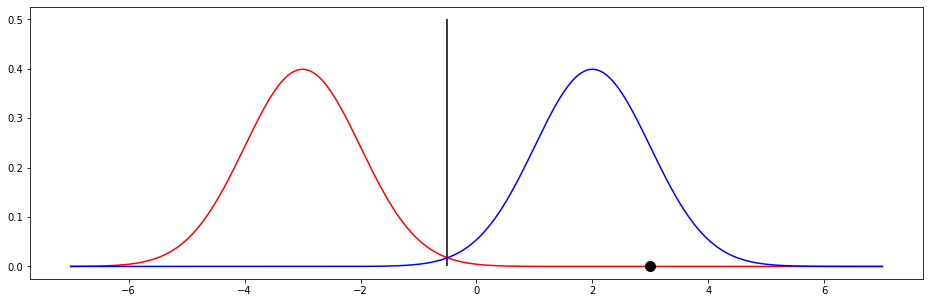

In [ ]:
x = np.linspace(-7, 7, 1000)
gaussian1 = prob_normal(x, -3, 1)
gaussian2 = prob_normal(x, 2, 1)

plt.figure(figsize=(16, 5))
plt.plot(x, gaussian1, "r")
plt.plot(x, gaussian2, "b")
plt.plot(3, 0, "ko", markersize=10)
plt.vlines(-0.5, 0, 0.5)

In [ ]:
def get_likelihoods(x, means, stds):
    features = means.columns
    target_names = means.index
    likelihoods = []
    for target in target_names:
        likelihood_target = 1
        for i, feat in enumerate(features):
            std = stds[feat].loc[target]
            mean = means[feat].loc[target]
            likelihood_target = likelihood_target * prob_normal(x[i], mean, std)
        likelihoods.append(likelihood_target)
    return likelihoods, target_names

Por último, para predecir $p(c_k|x)$ aplicamos el teorema de Bayes:

$p(c_k|x) = \frac{p(x|c_k)p(c_k)}{p(x)}$

El denominador al ser una constante normalizadora, como lo que queremos es encontrar el máximo, podemos descartarla.

$p(c_k|x) \propto p(x|c_k)p(c_k)$

Ya obtuvimos $p(x|c_k)$. En cuanto a $p(c_k)$ que es el prior, podríamos calcularlo viendo las proporciones de cada clase en el set de entrenamiento, o se podría dar la misma probabilidad a cada clase si queremos quitar el efecto del balance de clases.

Luego, para clasificar, querremos elegir aquella clase $c_k$ que sea más probable dados nuestros datos x. Esto en fórmulas es:

$argmax_k \: p(c_k|x)$

In [ ]:
def get_posteriors(x, means, stds, priors):
    likelihoods, target_names = get_likelihoods(x, means, stds)
    posteriors = likelihoods * priors
    return posteriors, target_names


def predict(x, means, stds, priors):
    posteriors, target_names = get_posteriors(x, means, stds, priors)
    return target_names[np.argmax(posteriors)]

En nuestro dataset sintético generamos múltiples clases, por lo que se trata de un problema de clasificación multiclase.

In [ ]:
test_set = dataset.sample(1000)
train_set = dataset.loc[~dataset.index.isin(test_set.index)]
test_set

,0,1,target
2496,-2.514179,7.417420,1
8500,-4.861296,7.777880,3
1459,7.727234,7.530733,4
2566,-6.271512,5.360834,3
3394,9.064089,7.945328,4
...,...,...,...
8315,-0.536512,7.315996,1
2852,5.680813,-5.787446,2
8327,4.867273,-4.158728,2
260,5.260610,-4.721163,2


In [ ]:
priors, means, stds = fit_gaussiannb(train_set)
y_true = test_set.target.values
x_test = test_set.drop("target", axis=1).values

y_pred = [predict(x, means, stds, priors) for x in x_test]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       194
           1       0.96      0.94      0.95       204
           2       1.00      1.00      1.00       221
           3       0.92      0.95      0.93       183
           4       1.00      1.00      1.00       198

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.98      0.97      0.98      1000



Podemos también ver la llamada matriz de confusión para analizar qué clases se confunde con cuáles nuestro clasificador:

Text(14.5, 0.5, 'Verdadero')

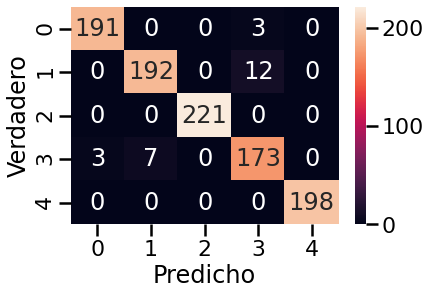

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set_context("poster")
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="g")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")

**A explorar**: Era esperable que de bien ya que nuestros datos sintéticos parecen estar distribuidos normalmente, sin embargo, ¿qué ocurrira si utilizamos distintas distribuciones?

En resumen
- Definimos una distribución para las clases (features continuas o discretas)
- Estimar los parámetros de las distribuciones de $p(.|c_k)$ usando el supuesto *naive* de independencia. En el caso gaussiano serían la media muestral $\hat\mu_k$ y el desvío muestral $\hat\sigma_k$ de cada clase $c_k$
- Para cada instancia, calculamos el posterior para cada clase $c_k$ usando la simplificación $p(c_k|x)\propto p(x|c_k) p(c_k)$ y predecimos la clase más probable, es decir el $k$ que maximixa el posterior

### Fronteras de decisión

![alt text](https://present5.com/presentation/24894f6ea1f629fbcc529b6179ea87f7/image-25.jpg)

In [ ]:
# Armado de la grilla:
grid = np.meshgrid(np.arange(-10, 10, 0.5), np.arange(-10, 10, 0.4))
x_vals = grid[0].reshape(-1, 1)
y_vals = grid[1].reshape(-1, 1)

# Armo un dataframe datos_frontera con todos los puntos de la grilla.
datos_frontera = pd.DataFrame(np.concatenate([x_vals, y_vals], axis=1))

In [ ]:
gnb_sklearn = GaussianNB()
gnb_sklearn.fit(train_set.drop("target", axis=1).values, train_set.target.values)
predictions = gnb_sklearn.predict(datos_frontera.values)

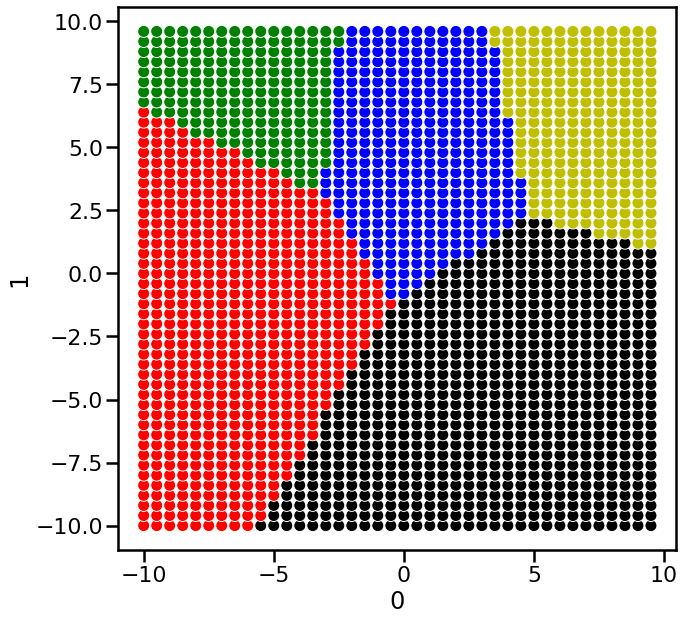

In [ ]:
datos_frontera["prediccion"] = predictions
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=0,
    y=1,
    hue="prediccion",
    data=datos_frontera,
    palette={0: "r", 1: "b", 2: "k", 3: "g", 4: "y"},
    legend=False,
)

## Ejemplo: Detección de Spam usando NB multinomial

Un uso clásico de Naive Bayes es detección de spam. En este caso en el cual utilizamos texto necesitamos poder construirnos variables/descriptores/features para representar cada texto. Para eso utilizamos *bag of words*, construiremos una matriz (conocida como matriz de términos-documentos) en la cuál tendremos todo el vocabulario del *corpus* (todas las palabras/términos que aparezcan a lo largo de todos los textos) y en cada fila representaremos cada texto, teniendo en cada entrada $c_{tk}$ de la fila la cantidad de apariciones de ese término $k$ en ese texto $t$.

In [ ]:
# carga de datos
from google.colab import files

spam_f = files.upload()
spam_dataset = pd.read_csv("datasets_483_982_spam.csv", encoding="latin-1")[
    ["v1", "v2"]
]
spam_dataset.sample(5)

Saving datasets_483_982_spam.csv to datasets_483_982_spam.csv


,v1,v2
1771,ham,Watching tv now. I got new job :)
4275,ham,Can you please send me my aunty's number
5050,ham,With my sis lor... We juz watched italian job.
4560,ham,Good afternoon my boytoy. How goes that walkin...
1194,ham,Ok... C ya...


In [ ]:
# preprocesamos para construir una variable target númerica usando las etiquetas en la columna v1
spam_dataset["is_spam"] = (spam_dataset["v1"] == "spam").astype(int)
spam_dataset["is_spam"].value_counts()
target = spam_dataset["is_spam"].values
target

array([0, 0, 1, ..., 0, 0, 0])

Transformar texto en Bag of Words usando el CountVectorizer de scikit learn

In [ ]:
bagger = CountVectorizer()
bow = bagger.fit_transform(list(spam_dataset["v2"]))

In [ ]:
bow.toarray().shape

(5572, 8672)

Esto quiere decir que nuestra matriz de Bag of Words tiene 5572 textos con un total de 8672 términos. Existen varias formas de construir esta matriz y varias decisiones de preprocesamiento de texto que se pueden tomar para la construcción de features. Una técnica muy utilizada son las transformaciones TF-IDF (ver TfidfVectorizer en la documentación de Scikit-Learn) las cuales utilizan frecuencias relativas para pesar las entradas de la matriz de términos-documentos.

En este caso, nuestras variables resultantes son discretas, por lo que necesitaríamos utilizar distribuciones discretas en lugar de continuas. Se suele utilizar la **distribución multinomial** (https://es.wikipedia.org/wiki/Distribuci%C3%B3n_multinomial). En este caso necesitamos estimar $p(t_k|c_k)$, es decir la probabilidad de ver un término $t_k$ cuando vemos textos de la clase $c_k$. Estimamos esa probabilidad contando cuantas veces ocurre la palabra $t_k$ en todos los textos de la clase $c_k$. El problema es que el vocabulario es muy sparse. Puede aparecer una palabra poco frecuente en nuestro texto que quizás solo vimos durante el entrenamiento para una sola de las clases. Esto lleva a estimar una probabilidad 0 para ese término, y no importa qué otras palabras haya en el documento ya que sus probabilidades quedarán multiplicadas por 0. Para aliviar ese problema se suele usar **Laplace smoothing** o **Lidstone smoothing**. Por default, la implementación de scikit learn utiliza Laplace ($\alpha=1$). Entonces ahora vamos a entrenar un modelo de Naive Bayes usando distribución multinomial para el cálculo de los likelihoods:

In [ ]:
# instanciamos nuestro modelo
nb = MultinomialNB()
# division de datos
x_train, x_test, y_train, y_test = train_test_split(
    bow, target, test_size=0.3, stratify=target
)
# entrenamos
nb.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred = nb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1448
           1       0.94      0.98      0.96       224

    accuracy                           0.99      1672
   macro avg       0.97      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672



## Referencias

- Capítulo 6.9 del libro Maching Learning de Tom Mitchell.
- Capítulo 2.3 del libro Machine Learning: An Algorithmic Perspective de Marsland.
- https://medium.com/datos-y-ciencia/algoritmos-naive-bayes-fudamentos-e-implementaci%C3%B3n-4bcb24b307f
- En inglés, (ver respuesta con más de mil votos): https://stackoverflow.com/questions/10059594/a-simple-explanation-of-naive-bayes-classification
- En inglés (avanzado): https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote05.html
- En inglés (avanzado): https://arxiv.org/pdf/1410.5329v3.pdf

***
# Ensambles

In [ ]:
from google.colab import files

diabetes_f = files.upload()

In [ ]:
import pandas as pd

diabetes = pd.read_csv("diabetes.csv")
print(diabetes.columns)
print(len(diabetes))

In [ ]:
diabetes["Outcome"].value_counts()

In [ ]:
import seaborn as sns

sns.countplot(diabetes["Outcome"], label="Count")

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    diabetes.loc[:, diabetes.columns != "Outcome"],
    diabetes["Outcome"],
    stratify=diabetes["Outcome"],
    random_state=66,
)

## Basados en bagging

Combinan strong learners, los cuales tienen varianza alta, para reducir su varianza. El bagging consiste en utilizar distintos subsets de los datos de entrenamiento para entrenar cada learner. Los subsets se generan tomando muestras con reemplazo. Si no se hace reemplazo se denomina **pasting**, y si en lugar de tomar subsets sobre los datos, los tomamos sobre los atributos, se denomina **random subspaces**. La combinación de bagging y random subspaces se denomina **random patches**.


https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting

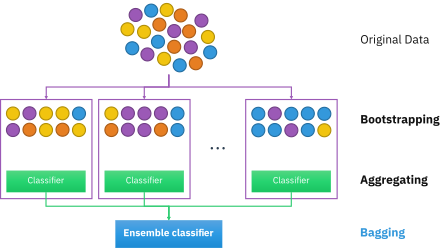

Scikit Learn cuenta un tipo de objetos llamados *meta-estimadores* para representar a los ensambles. Este nombre se debe a que estos meta-estimadores necesitan definir estimadores *base* que van a ser justamente los modelos que se ajusten en cada uno de los pasos de bootstrapping. Como modelos/estimadores base podemos instanciar cualquier estimador de sklearn. Para el caso de Bagging, el meta-estimador para clasificación es:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Este objeto tiene como principal parámetro a **base_estimator** en el cual instanciaremos un modelo. Veamos un pequeño ejemplo:

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bg = BaggingClassifier(
    KNeighborsClassifier(n_neighbors=4), max_samples=0.5, max_features=0.5
)

# max_samples en float nos dice que porcentaje del training set queremos remuestrear
# max_features nos da un grado mas de aleatorizacion, muestreo en las columnas/features del conjunto de datos

# fit
bg.fit(X_train, y_train)

# evaluación
print("Accuracy training : {:.3f}".format(bg.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(bg.score(X_test, y_test)))

En esta implementación del *BaggingClassifier* no es necesario usar estimadores base que sean *strong learners*, podemos usar cualquier tipo de estimador. Sin embargo, para que bagging performe mejor que el modelo base, si es necesaria esta condición. En el ejemplo recien visto, KNN con 4 vecinos, no es un modelo que pueda sobreajustar tanto como un arbol de profundidad arbitriaria, por lo tanto, no se consideraría un strong learner. Veamos que sucede si utilizabamos el mismo modelo sin bagging

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)

# max_samples en float nos dice que porcentaje del training set queremos remuestrear
# max_features nos da un grado mas de aleatorizacion, muestreo en las columnas/features del conjunto de datos

# fit
knn.fit(X_train, y_train)

# evaluación
print("Accuracy training : {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(knn.score(X_test, y_test)))

En este caso el resultado es muy similar, levemente superior en bagging, pero no se ve una fuerte mejora frente al modelo base, la mejora es marginal. 

### Random Forests

Random Forest es una implementación de un algoritmo de *Bagging* que propone como estimadores base a **n_estimators** árboles de decisión. Cada árbol verá un subset distinto de los datos de entrenamiento (bagging, llamado **bootstrap** en los parámetros de sklearn). A su vez, para elegir el mejor split en cada nivel, se tienen en cuenta solo **max_features** atributos, seleccionados al azar. Estas 2 técnicas combinadas llevan a obtener árboles que sean distintos entre si y estén decorrelacionados, lo cual es bueno ya que si un árbol comete errores, probablemente otros no lo cometerán y se compensarán. Cuanto más independientes sean los árboles entre si más reduciremos la varianza.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

parameters = {
    "n_estimators": range(50, 500, 10),
    "max_depth": range(1, 6),
    "bootstrap": [True, False],
}
clf = RandomizedSearchCV(
    RandomForestClassifier(max_features=None),
    parameters,
    n_jobs=10,
    scoring="accuracy",
    cv=5,
    n_iter=50,
)

clf.fit(X_train, y_train)
rf = clf.best_estimator_
print(clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

In [ ]:
pd.DataFrame(clf.cv_results_).sample(3)

In [ ]:
diabetes_features = [x for i, x in enumerate(diabetes.columns) if i != 8]
feat_importances = rf.feature_importances_

sns.barplot(
    y=diabetes_features,
    x=feat_importances,
    orient="h",
    order=reversed(np.array(diabetes_features)[np.argsort(feat_importances)]),
)

### Fronteras de decisión

![alt text](https://miro.medium.com/max/1776/1*9MixqU7EW3v2I0fIvT8AQQ.png)

![alt text](https://i.stack.imgur.com/RFmcL.png)

### Extremely Randomized Trees

Similar a random forest pero además, en cada nivel del árbol, los splits son tomados al azar en lugar de buscar el óptimo. Random Forest elige la división óptima, mientras que Extra Trees la elige al azar. Sin embargo, una vez que se seleccionan los puntos de división, los dos algoritmos eligen el mejor entre todos los subconjuntos de features. Por lo tanto, Extra Trees agrega aleatorización pero aún tiene optimización, elige el feature con el cual se consiguió una muestra más pura con el corte aleatorio.

Es importante notar que al eliminar esta capa de optimización, el algoritmo en general será más rápido.

Es más robusto a la presencia de atributos ruidosos o poco informativos.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

clf = RandomizedSearchCV(
    ExtraTreesClassifier(), parameters, n_jobs=10, scoring="accuracy", cv=5, n_iter=50
)

clf.fit(X_train, y_train)
et = clf.best_estimator_
print(clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(et.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(et.score(X_test, y_test)))

## Basados en Boosting

Los algoritmos de boosting, en lugar de entrenar de forma paralela los árboles utilizando distintos subsets de los datos, entrenan cada árbol de manera secuencial. Un concepto importante es que combinan weak learners (alto sesgo, baja varianza) para hacer un strong learner reduciendo el sesgo.

La forma en que combinan los weak learners es haciendo que cada nuevo learner corrija los errores del anterior. Un weak learner típico es un árbol de profundidad 1 (stump) o árboles con muy poca profundidad.

Lecturas e imagenes extraidas de:
- https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting
- https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

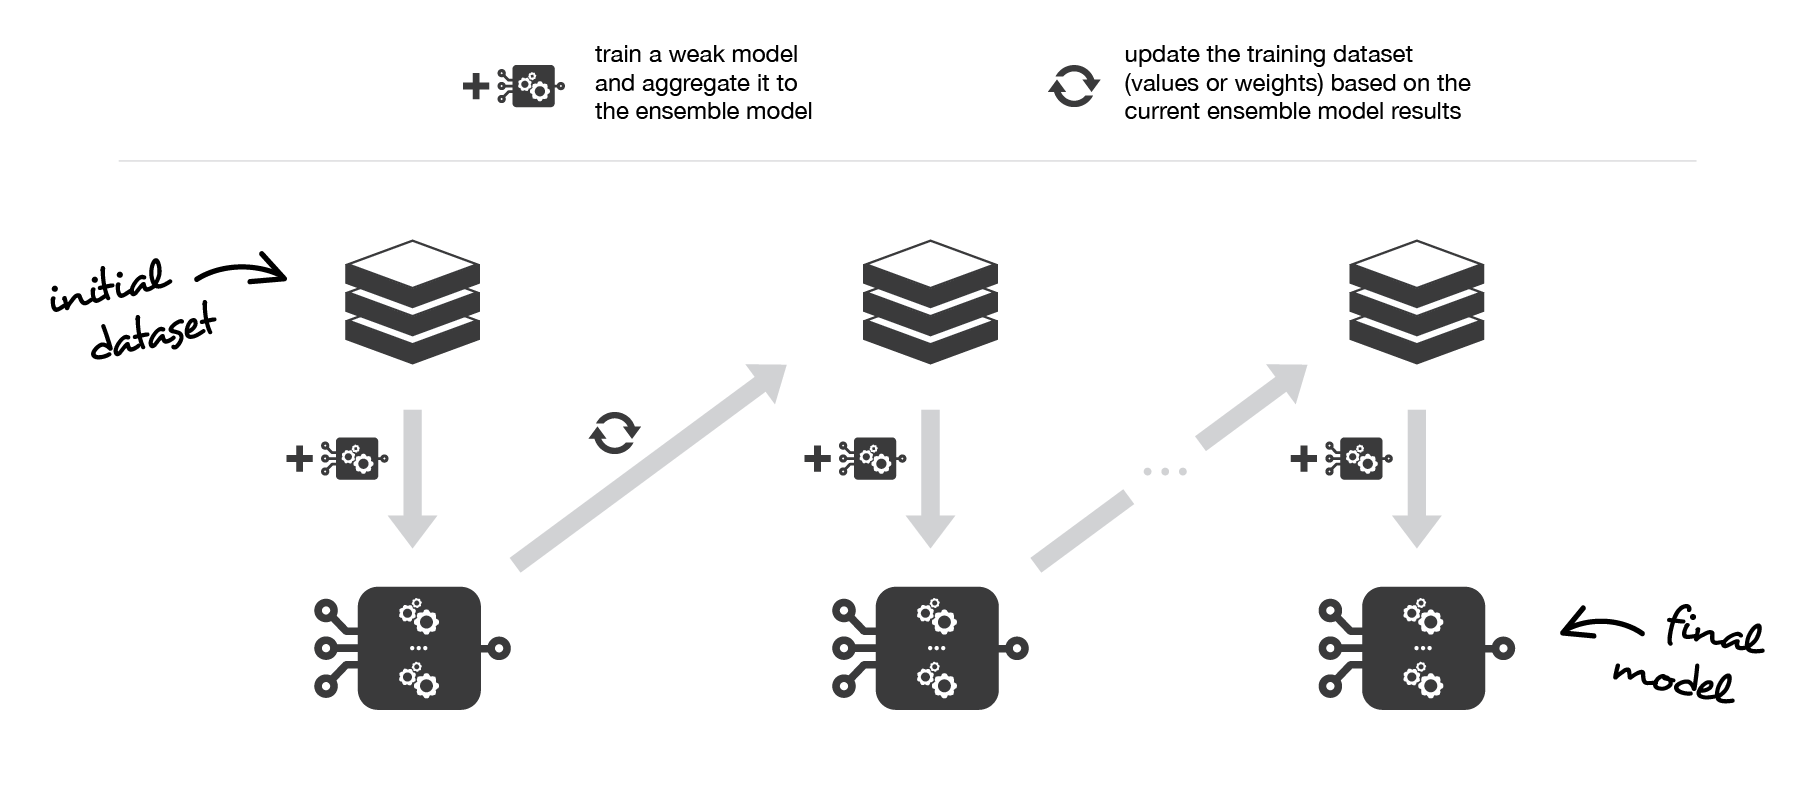

### AdaBoost
En cada iteración construye un stump nuevo y le da más peso a las muestras que fueron clasificadas mal por el anterior stump. De esta manera, en cada iteración se intenta corregir los errores que cometió el anterior clasificador. Una vez armado el ensamble, cada stump tendrá asociado un peso en sus predicciones de acuerdo a qué tan bueno fue clasificando durante el entrenamiento. A continuación les dejamos un video explicativo del funcionamiento del algoritmo:

https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmerStatQuestwithJoshStarmerVerified

La implementación de AdaBoost de sklearn nos provee de un meta-estimador para Boosting, al cual le podemos pasar cualquier estimador (por defecto usa un arbol de profundidad 1, un stump):

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier

Paper original:
https://web.stanford.edu/~hastie/Papers/samme.pdf 


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {"n_estimators": range(50, 200, 5), "learning_rate": np.arange(0, 1, 0.01)}
clf = RandomizedSearchCV(
    AdaBoostClassifier(), parameters, n_jobs=10, scoring="accuracy", cv=5, n_iter=50
)

clf.fit(X_train, y_train)
ab = clf.best_estimator_
print(clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(ab.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(ab.score(X_test, y_test)))

### Gradient Boosting (GBM)

Permite elegir una función de costo $L$, por ejemplo, error cuadrático medio si es un problema de regresión, o entropía cruzada si es un problema de clasificación, y cada árbol que construye lo hace de manera que la función de costo se minimice yendo en dirección opuesta al gradiente de la función de costo. Esta técnica de optimización se denomina descenso por gradiente.

![alt text](https://miro.medium.com/max/1400/1*wsBakfF2Geh1zgY4HJbwFQ.gif)

Matematicamente esto significa que cada nueva predicción 

(1) $\hat{y_t} = \hat{y}_{t-1} - \lambda\frac{\partial L}{\partial \hat{y_t}}$

En donde $\lambda$ es la tasa de aprendizaje.

En el caso de error cuadrático:

$L = (y_t - \hat{y}_t)^2$

$\frac{\partial L}{\partial \hat{y_t}} = -2(y_t - \hat{y}_t)$

La parte mágica es que en cada iteración construimos un árbol nuevo que aprenda a predecir $\frac{\partial L}{\partial \hat{y_t}}$, que en este caso es el residuo entre las observaciones y los valores predichos por el árbol anterior. 

Es decir, en este caso cada árbol nuevo lo entreno para que prediga el residuo entre las observaciones y las predicciones anteriores. Luego combino las predicciones de los árboles utilizando la ecuación 1.

En el caso de clasificación, cada árbol va a predecir la diferencia entre la probabilidad asignada a la clase y el outcome de esa clase.

https://www.youtube.com/watch?v=3CC4N4z3GJc&ab_channel=StatQuestwithJoshStarmerStatQuestwithJoshStarmerVerified

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    "n_estimators": range(20, 200, 5),
    "max_depth": range(1, 7),
    "learning_rate": np.arange(0, 1, 0.001),
}
clf = RandomizedSearchCV(
    GradientBoostingClassifier(),
    parameters,
    n_jobs=10,
    scoring="accuracy",
    cv=5,
    n_iter=50,
)

clf.fit(X_train, y_train)
gb = clf.best_estimator_
print(clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(gb.score(X_test, y_test)))

### Otros: XGBoost, LightGBM, CatBoost

Existen múltiples implementaciones de los algoritmos de boosting, siendo uno de los más populares el **Extreme Gradient Boosting (XGBoost)** (de los más utilizados en Kaggle junto a los distintos tipos de redes neuronales). Pueden ver una explicación de sus detalles en: https://xgboost.readthedocs.io/en/latest/tutorials/model.html. Luego de la aparición de este algoritmo, surgieron varias empresas que crearon sus versiones, entre ellas Microsoft(**LigthGBM**) y Yandex(**CatBoost**). Estas implementaciones mejoran algunas de las características de XGBoost, como incorporar manejo directo de variables categóricas, manejo de valores faltantes, funciones de pérdida personalizadas y mejoras de complejidad algorítmica. Pueden encontrar una mayor comparativa entre estos algoritmos en https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db. Librerías de cada uno de estos algorítmos:

- XGBoost: https://xgboost.readthedocs.io/en/latest/
- LightGBM: https://lightgbm.readthedocs.io/en/latest/#
- CatBoost: https://catboost.ai/
